In [1]:
import re
import string
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz, process
from shapely.geometry.multipolygon import MultiPolygon

%matplotlib inline

In [70]:
h1b = pd.read_csv("../dat/clean_emp_jobs.csv")

In [72]:
h1b = h1b.loc[h1b["lca_case_employment_start_date"] < "2015-01-01", :]

In [126]:
h1b["lca_case_employment_start_date"] = pd.to_datetime(h1b["lca_case_employment_start_date"])
h1b["lca_case_employment_end_date"] = pd.to_datetime(h1b["lca_case_employment_end_date"])
h1b.loc[(h1b["lca_case_employment_end_date"] - h1b["lca_case_employment_start_date"]) > pd.Timedelta("{:} days".format(1095)), :]

,Unnamed: 0,lca_case_number,lca_case_submit,decision_date,visa_class,lca_case_employment_start_date,lca_case_employment_end_date,lca_case_employer_name,lca_case_employer_address,lca_case_employer_city,...,other_wage_source_2,yr_source_pub_2,lca_case_naics_code,intzips,emp_full_addr,emp_unique_addrs,n_unique_addrs,soc_fam,seniority,frac_wage_rate_to
0,0,I-200-09162-143337,2014-03-17,2014-03-21,H-1B,2014-09-15,2017-09-15,EYE SPECIALISTS OF INDIANA PC,1901 N. MERIDIAN ST.,INDIANAPOLIS,...,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,62,46202.0,1901 N. MERIDIAN ST. INDIANAPOLIS IN 46202,1901 N MERIDIAN ST INDIANAPOLIS IN 46202,1,29.0,0,0.000000
4,4,I-200-09230-596710,2014-08-06,2014-08-12,H-1B,2014-09-05,2017-09-05,DEWBERRY ENGINEERS INC,8401 ARLINGTON BLVD,FAIRFAX,...,NaN,NaN,54,22031.0,8401 ARLINGTON BLVD FAIRFAX VA 22031-4666,8401 ARLINGTON BLVD FAIRFAX VA 220314666,2,17.0,0,0.000000
5,5,I-200-09231-610493,2013-10-18,2013-10-26,H-1B,2013-11-04,2016-11-04,CAREMARK LLC,750 W. JOHN CARPENTER FREEWAY,IRVING,...,NaN,NaN,42,75039.0,750 W. JOHN CARPENTER FREEWAY IRVING TX 75039,750 W JOHN CARPENTER FREEWAY IRVING TX 75039,2,15.0,0,0.312119
6,6,I-200-09244-448752,2013-10-30,2013-11-05,H-1B,2013-11-04,2016-11-04,CAREMARK LLC,750 W. JOHN CARPENTER FREEWAY,IRVING,...,NaN,NaN,42,75039.0,750 W. JOHN CARPENTER FREEWAY IRVING TX 75039,750 W JOHN CARPENTER FREEWAY IRVING TX 75039,2,15.0,0,0.203906
7,7,I-200-09253-169906,2014-09-10,2014-09-16,H-1B,2014-09-10,2017-09-10,LOGISTIC SOLUTIONS INC,216 STELTON ROAD,PISCATAWAY,...,NaN,NaN,54,NaN,216 STELTON ROAD PISCATAWAY NJ 8854,216 STELTON ROAD PISCATAWAY NJ 8854,2,15.0,0,0.000000
8,8,I-200-09259-849209,2014-03-12,2014-03-18,H-1B,2014-09-10,2017-09-10,FRS AMERICA INC,2700 LAKE COOK ROAD,RIVERWOODS,...,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,51,60015.0,2700 LAKE COOK ROAD RIVERWOODS IL 60015,2700 LAKE COOK ROAD RIVERWOODS IL 60015,1,11.0,1,0.004497
10,10,I-200-09267-929154,2014-04-23,2014-04-29,H-1B,2014-06-05,2017-06-05,CCH INCORPORATED,2700 LAKE COOK ROAD,RIVERWOODS,...,NaN,NaN,51,60015.0,2700 LAKE COOK ROAD RIVERWOODS IL 60015,2700 LAKE COOK ROAD RIVERWOODS IL 60015,1,15.0,1,0.824331
13,13,I-200-09273-620055,2014-05-01,2014-05-07,H-1B,2014-07-19,2017-07-19,CCH INCORPORATED,2700 LAKE COOK ROAD,RIVERWOODS,...,NaN,NaN,51,60015.0,2700 LAKE COOK ROAD RIVERWOODS IL 60015,2700 LAKE COOK ROAD RIVERWOODS IL 60015,1,11.0,1,0.206406
22,22,I-200-09321-500817,2014-03-25,2014-03-31,H-1B,2014-09-24,2017-09-24,HDK ENTERPRISES INC,7700 MAIN STREET,HOUSTON,...,NaN,NaN,42,77030.0,7700 MAIN STREET HOUSTON TX 77030-4456,7700 MAIN STREET HOUSTON TX 770304456,1,13.0,0,0.000000
24,24,I-200-09327-169757,2013-10-30,2013-11-05,H-1B,2013-11-18,2016-11-18,CAREMARK LLC,750 W. JOHN CARPENTER FREEWAY,IRVING,...,NaN,NaN,42,75039.0,750 W. JOHN CARPENTER FREEWAY IRVING TX 75039,750 W JOHN CARPENTER FREEWAY IRVING TX 75039,2,15.0,0,0.355402


In [73]:
h1b.shape

(437099, 38)

In [74]:
h1b.dropna(subset=["lca_case_workloc2_state"])[pd.isnull(h1b.lca_case_workloc2_city)]

/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,lca_case_number,lca_case_submit,decision_date,visa_class,lca_case_employment_start_date,lca_case_employment_end_date,lca_case_employer_name,lca_case_employer_address,lca_case_employer_city,...,other_wage_source_2,yr_source_pub_2,lca_case_naics_code,intzips,emp_full_addr,emp_unique_addrs,n_unique_addrs,soc_fam,seniority,frac_wage_rate_to
27690,27690,I-200-13304-537193,2013-11-02,2013-11-07,H-1B,2013-11-05,2016-11-04,PINE TREE HOME HEALTH CARE INC,"1125 JUDSON RD., STE. 193",LONGVIEW,...,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,62,75601.0,"1125 JUDSON RD., STE. 193 LONGVIEW TX 75601",1125 JUDSON RD STE 193 LONGVIEW TX 43085,1,29.0,0,0.0
27914,27914,I-200-13304-708661,2013-11-02,2013-11-07,H-1B,2013-11-05,2016-11-04,PINE TREE HOME HEALTH CARE INC,"1125 JUDSON RD., STE. 193",LONGVIEW,...,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,62,43085.0,"1125 JUDSON RD., STE. 193 LONGVIEW TX 43085",1125 JUDSON RD STE 193 LONGVIEW TX 43085,1,29.0,0,0.0
122952,122952,I-200-14045-211105,2014-02-27,2014-03-05,H-1B,2014-08-27,2017-08-26,LAKSHMI PT CONSULTANTS PC,"865 MERRICK RD., STE. 201",BALDWIN,...,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,62,11510.0,"865 MERRICK RD., STE. 201 BALDWIN NY 11510",865 MERRICK RD STE 201 BALDWIN NY 11510,1,29.0,0,0.0
126226,126226,I-200-14048-083040,2014-02-20,2014-02-26,H-1B,2014-06-08,2017-06-07,LAKSHMI PT CONSULTANTS PC,"865 MERRICK RD., STE# 201",BALDWIN,...,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,62,11510.0,"865 MERRICK RD., STE. 201 BALDWIN NY 11510",865 MERRICK RD STE 201 BALDWIN NY 11510,1,29.0,0,0.0
131610,131610,I-200-14050-358804,2014-02-20,2014-02-26,H-1B,2014-08-20,2017-08-19,LAKSHMI PT CONSULTANTS PC,"865 MERRICK RD., STE# 201",BALDWIN,...,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,62,11510.0,"865 MERRICK RD., STE. 201 BALDWIN NY 11510",865 MERRICK RD STE 201 BALDWIN NY 11510,1,29.0,0,0.0
133328,133328,I-200-14050-978313,2014-02-20,2014-02-26,H-1B,2014-06-08,2017-06-07,LAKSHMI PT CONSULTANTS PC,"865 MERRICK RD., STE# 201",BALDWIN,...,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,62,11510.0,"865 MERRICK RD., STE. 201 BALDWIN NY 11510",865 MERRICK RD STE 201 BALDWIN NY 11510,1,29.0,0,0.0
145012,145012,I-200-14056-487616,2014-02-26,2014-03-04,H-1B,2014-06-08,2017-06-07,LAKSHMI PT CONSULTANTS PC,"865 MERRICK RD., STE. 201",BALDWIN,...,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,62,11510.0,"865 MERRICK RD., STE. 201 BALDWIN NY 11510",865 MERRICK RD STE 201 BALDWIN NY 11510,1,29.0,0,0.0
151451,151451,I-200-14058-273024,2014-02-27,2014-03-05,H-1B,2014-08-27,2017-08-26,LAKSHMI PT CONSULTANTS PC,865 MERRICK RD.,BALDWIN,...,'OFLC ONLINE DATA CENTER','OFLC ONLINE DATA CENTER',62,11510.0,"865 MERRICK RD., STE. 201 BALDWIN NY 11510",865 MERRICK RD STE 201 BALDWIN NY 11510,1,29.0,0,0.0
151737,151737,I-200-14058-357207,2014-02-27,2014-03-05,H-1B,2014-08-27,2017-08-26,LAKSHMI PT CONSULTANTS PC,865 MERRICK RD.,BALDWIN,...,'OFLC ONLINE DATA CENTER','OFLC ONLINE DATA CENTER',62,11510.0,"865 MERRICK RD., STE. 201 BALDWIN NY 11510",865 MERRICK RD STE 201 BALDWIN NY 11510,1,29.0,0,0.0
152829,152829,I-200-14058-663001,2014-02-27,2014-03-05,H-1B,2014-08-27,2017-08-26,LAKSHMI PT CONSULTANTS PC,865 MERRICK RD.,BALDWIN,...,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,62,11510.0,"865 MERRICK RD., STE. 201 BALDWIN NY 11510",865 MERRICK RD STE 201 BALDWIN NY 11510,1,29.0,0,0.0


In [75]:
# first let's do an NY only dataframe
nyc_nabes = json.loads(open("../dat/ext/nyc_nabe_names.json").read())

In [76]:
nyc_nabes["features"][0]

{'geometry': {'coordinates': [-73.8472019292043, 40.8947134741554],
  'type': 'Point'},
 'id': 1,
 'properties': {'AnnoAngle': 0,
  'AnnoLine1': 'Wakefield',
  'AnnoLine2': ' ',
  'AnnoLine3': ' ',
  'Borough': 'Bronx',
  'FID': 1,
  'Name': 'Wakefield',
  'Stacked': 1},
 'type': 'Feature'}

In [77]:
nabe_boros = [feat["properties"]["Borough"] for feat in nyc_nabes["features"]]

In [78]:
nabe_names = [feat["properties"]["Name"] for feat in nyc_nabes["features"]]
nabe_dict = {feat["properties"]["Name"]: feat["properties"]["Borough"] for feat in nyc_nabes["features"]}

In [79]:
[[nabe_names[i], nabe_boros[i]] for i in range(len(nabe_names))]
# this could be troublesome because some places are ambiguous
# e.g. Eastchester is a neighbourhood in the Bronx but also a town in Westchester county...

[['Wakefield', 'Bronx'],
 ['Co-op City', 'Bronx'],
 ['Eastchester', 'Bronx'],
 ['Fieldston', 'Bronx'],
 ['Riverdale', 'Bronx'],
 ['Kingsbridge', 'Bronx'],
 ['South Beach', 'Staten Island'],
 ['Marble Hill', 'Manhattan'],
 ['Port Richmond', 'Staten Island'],
 ['Woodlawn', 'Bronx'],
 ["Mariner's Harbor", 'Staten Island'],
 ['Norwood', 'Bronx'],
 ['Port Ivory', 'Staten Island'],
 ['Williamsbridge', 'Bronx'],
 ['Castleton Corners', 'Staten Island'],
 ['Baychester', 'Bronx'],
 ['New Springville', 'Staten Island'],
 ['Pelham Parkway', 'Bronx'],
 ['Travis', 'Staten Island'],
 ['City Island', 'Bronx'],
 ['New Dorp', 'Staten Island'],
 ['Bedford Park', 'Bronx'],
 ['Oakwood', 'Staten Island'],
 ['University Heights', 'Bronx'],
 ['Great Kills', 'Staten Island'],
 ['Morris Heights', 'Bronx'],
 ['Eltingville', 'Staten Island'],
 ['Fordham', 'Bronx'],
 ['Annadale', 'Staten Island'],
 ['East Tremont', 'Bronx'],
 ['Woodrow', 'Staten Island'],
 ['West Farms', 'Bronx'],
 ['Tottenville', 'Staten Island']

In [80]:
# get just NY data
nycdf = h1b.loc[np.logical_or(h1b.lca_case_workloc1_state == "NY", h1b.lca_case_workloc2_state == "NY"), :]
nycdf = nycdf.drop(nycdf[np.logical_and(nycdf.lca_case_workloc2_state == "NY", pd.isnull(nycdf.lca_case_workloc2_city))].index)
nycdf.shape

(41677, 38)

In [81]:
ny_cities = nycdf[h1b.lca_case_workloc1_state == "NY"].dropna(subset=["lca_case_workloc1_city"])
ny_cities = ny_cities["lca_case_workloc1_city"].unique()
ny_cities
len(ny_cities)

/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


638

In [82]:
ny_cities_2 = nycdf[h1b.lca_case_workloc2_state == "NY"].dropna(subset=["lca_case_workloc2_city"])
ny_cities_2 = ny_cities_2["lca_case_workloc2_city"].unique()
ny_cities_2
# len(ny_cities_2)

/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


array(['NEW YORK', 'FLUSHING', 'ALBANY', 'BRONX', 'FARMINGDALE',
       'LIVERPOOL', 'GLENS FALLS', 'NEW WINDSOR', 'BUFFALO', 'UPTON',
       'BROOKLYN', '3RD FLOOR', 'HICKSVILLE, NY', 'DUNKIRK', 'HICKSVILLE',
       'RIDGEWOOD', 'BABYLON', 'COLONIE', 'SCHENECTADY', 'WHITE PLAINS',
       'GREAT NECK', 'NEW HYDE PARK', 'TROY', 'WARRENSBURG', 'WOODBURY',
       'MELVILLE', 'CLIFTON PARK', 'PEARL RIVER', 'FOREST HILLS',
       'HAWTHORNE', 'NEW YORK CITY', 'PISCATAWAY', 'CORNING', 'RYE BROOK',
       'ELMHURST', 'WILLIAMSVILLE', 'ROCHESTER', 'JACKSON HEIGHTS',
       'POUGHKEEPSIE', 'S RICHMOND HILL', 'YORKTOWN HEIGHTS', 'SEAFORD',
       'TARRYTOWN', 'RENSSELAER', 'FRESH MEADOWS', 'DELMAR', 'SYRACUSE',
       'GREENE', 'RYE', 'NEW HAMPTON', 'LONG ISLAND CITY', 'AMHERST',
       'FREEPORT', 'SUFFERN', 'SENECA FALLS', 'JAMAICA', 'STONY BROOK',
       'IRONDEQUOIT', 'HAUPPAUGE', 'MANHATTAN', 'GATES', 'TONAWANDA',
       'ARMONK', 'UTICA', 'CORTLAND', 'LAKE SUCCESS', 'BETHPAGE',
       'PUR

In [83]:
ny_cities = list(set(ny_cities).union(set(ny_cities_2)))

In [84]:
nabe_boros = list(set(nabe_boros))
ny_cities

['OSWEGO',
 'NIAGARA FALLS',
 'LEVITTOWN',
 'BRENTWOOD',
 'WHITETONE',
 'GLENMONT',
 'BROOKVILLE',
 'ISELIN',
 'SARATOGA SPRINGS',
 'JAMESTOWN',
 'SCHENECTADY',
 'BOHEMIA',
 'WHITE PLAINS',
 'DEWITT',
 'LAKEWOOD',
 'VESTAL',
 'HOUGHTON',
 'BARDONIA',
 'BALITMORE',
 'WEST HAMPTON BEACH',
 'STONY BROOK',
 'TUXEDO',
 'HORSEHEADS',
 'KEW GARDENS',
 'VALHALL',
 'ST. ALBANS',
 'WILLIAMSBURGH',
 'CENTER MORICHES',
 'MANHATTAN, NEW YORK',
 'SCOTTSVILLE',
 'MASSENA',
 'BEDMINSTER',
 'CLIFTON SPRINGS',
 'ORANGEBURG',
 'SCHENECTADYæ',
 'LIBERTY',
 'ORCHARD PARK',
 'LYNBROOK',
 'MIDDLEBURGH',
 'NEW ROCHELLE',
 'MELVILLE',
 'SMYRNA',
 'WOODBURRY',
 'PO BOX 299',
 'PORT JEFFERSON STATION',
 'SILVER CREEK',
 'LONG BEACH',
 'BALLSTON SPA',
 'LONG ISLAND',
 'HOPEWELL JCT',
 'CORFU',
 'FARMINGDALE',
 '#35620 OZONE PARK NY MSA',
 'NEWARK',
 'NAPANOCH',
 'WEST MENANDS',
 'PARSIPPANY',
 'FRAMINGDALE',
 'AIRMONT',
 'TUCKAHOE',
 'GREAT NECK,',
 'TEWKSBURY',
 'CANANDAIGUA',
 'GREAT RIVER',
 'OZONE PARK',
 'NY

In [85]:
# let's do a borough pass first, should be safe, then do neighbourhoods and see what's left
boro_matches = [process.extractOne(city, nabe_boros) for city in ny_cities]
boro_matches

[('Brooklyn', 29),
 ('Manhattan', 34),
 ('Bronx', 36),
 ('Bronx', 54),
 ('Manhattan', 44),
 ('Bronx', 36),
 ('Brooklyn', 67),
 ('Staten Island', 60),
 ('Staten Island', 41),
 ('Staten Island', 36),
 ('Staten Island', 42),
 ('Staten Island', 39),
 ('Staten Island', 48),
 ('Staten Island', 43),
 ('Staten Island', 34),
 ('Staten Island', 43),
 ('Bronx', 40),
 ('Bronx', 62),
 ('Bronx', 29),
 ('Staten Island', 45),
 ('Brooklyn', 60),
 ('Queens', 33),
 ('Queens', 45),
 ('Queens', 47),
 ('Manhattan', 38),
 ('Staten Island', 52),
 ('Bronx', 36),
 ('Staten Island', 36),
 ('Manhattan', 90),
 ('Staten Island', 42),
 ('Manhattan', 50),
 ('Queens', 45),
 ('Staten Island', 36),
 ('Bronx', 36),
 ('Staten Island', 42),
 ('Brooklyn', 40),
 ('Staten Island', 30),
 ('Brooklyn', 62),
 ('Bronx', 36),
 ('Bronx', 36),
 ('Staten Island', 34),
 ('Manhattan', 45),
 ('Bronx', 36),
 ('Bronx', 54),
 ('Bronx', 54),
 ('Queens', 43),
 ('Bronx', 34),
 ('Staten Island', 48),
 ('Staten Island', 67),
 ('Queens', 30),
 ('

In [86]:
[[ny_cities[i], boro_matches[i]] for i in range(len(ny_cities)) if boro_matches[i][1] >= 80]

[['MANHATTAN, NEW YORK', ('Manhattan', 90)],
 ['WILLIAMSBURG, BROOKLYN', ('Brooklyn', 90)],
 ['BROOKLY', ('Brooklyn', 93)],
 ['FOREST HILLS QUEENS', ('Queens', 90)],
 ['MANHATAN', ('Manhattan', 94)],
 ['BRONX,NY', ('Bronx', 90)],
 ['BRONXVILLE', ('Bronx', 90)],
 ['STATEN ISLAND', ('Staten Island', 100)],
 ['BROOKLYN', ('Brooklyn', 100)],
 ['DOWNTOWN BROOKLYN', ('Brooklyn', 90)],
 ['BRONX', ('Bronx', 100)],
 ['BRONX,NEW YORK', ('Bronx', 90)],
 ['QUEENS', ('Queens', 100)],
 ['BROOKYLN', ('Brooklyn', 88)],
 ['MANHATTAN', ('Manhattan', 100)],
 ['QUEENSBURY', ('Queens', 90)],
 ['BROOKYN', ('Brooklyn', 93)],
 ['BRONX.NEW YORK', ('Bronx', 90)],
 ['BRONX, NEW YORK', ('Bronx', 90)],
 ['QUEENS VILLAGE', ('Queens', 90)],
 ['BROOKLN', ('Brooklyn', 93)],
 ['BROOKLYN,', ('Brooklyn', 100)],
 ['MIDTOWN MANHATTAN', ('Manhattan', 90)]]

In [87]:
# downtown brooklyn is a neighbourhood, as is midtown
[n for n in nyc_nabes["features"] if n["properties"]["Name"] == "Downtown"]

[{'geometry': {'coordinates': [-73.9834648142757, 40.6908522739855],
   'type': 'Point'},
  'id': 173,
  'properties': {'AnnoAngle': 0,
   'AnnoLine1': 'Downtown',
   'AnnoLine2': ' ',
   'AnnoLine3': ' ',
   'Borough': 'Brooklyn',
   'FID': 173,
   'Name': 'Downtown',
   'Stacked': 1},
  'type': 'Feature'}]

In [88]:
# these are the "cities" with no more specific info than the borough
good_boros = [ny_cities[i] for i in range(len(ny_cities)) if boro_matches[i][1] >= 80]
good_boros.remove("DOWNTOWN BROOKLYN")
good_boros.remove("WILLIAMSBURG, BROOKLYN")
good_boros.remove("FOREST HILLS QUEENS")
good_boros.remove("QUEENS VILLAGE")
good_boros.remove("BRONXVILLE")
good_boros.remove("QUEENSBURY")
good_boros.remove("MIDTOWN MANHATTAN")

In [89]:
# make a borough column for nycdf
nycdf["borough"] = ["" for i in range(nycdf.shape[0])]
# and dummy city columns to keep track of the ones we're done with
nycdf["dummy_city_1"] = nycdf.loc[:, "lca_case_workloc1_city"]
nycdf["dummy_city_2"] = nycdf.loc[:, "lca_case_workloc2_city"]
for boro in good_boros:
    cityind = ny_cities.index(boro)
    nycdf.loc[nycdf.lca_case_workloc1_city == boro, ["borough"]] = boro_matches[cityind][0]
    nycdf.loc[nycdf.lca_case_workloc1_city == boro, ["dummy_city_1"]] = np.nan
    nycdf.loc[nycdf.lca_case_workloc2_city == boro, ["borough"]] = boro_matches[cityind][0]
    nycdf.loc[nycdf.lca_case_workloc2_city == boro, ["dummy_city_2"]] = np.nan

In [90]:
nabe_matches = [process.extractOne(city, nabe_names) for city in ny_cities]
nabe_matches

[('Holliswood', 50),
 ('Great Kills', 58),
 ('Clifton', 62),
 ('Inwood', 75),
 ('Whitestone', 95),
 ('Claremont Village', 68),
 ('Brookville', 100),
 ('City Island', 60),
 ('Pleasant Plains', 52),
 ('Charleston', 63),
 ('Sheepshead Bay', 56),
 ('Boerum Hill', 56),
 ('Pleasant Plains', 64),
 ('Edgewater Park', 60),
 ('Oakwood', 80),
 ('Riverdale', 60),
 ('Douglaston', 67),
 ('Bronxdale', 59),
 ('Bellaire', 59),
 ('South Beach', 86),
 ('Willowbrook', 55),
 ('Tudor City', 60),
 ('Fresh Meadows', 61),
 ('Kew Gardens', 100),
 ('Central Harlem', 64),
 ('St. Albans', 100),
 ('Williamsburg', 96),
 ('Jamaica Center', 66),
 ('New Dorp', 86),
 ('Tottenville', 73),
 ('Maspeth', 57),
 ('Baychester', 60),
 ('Clifton', 90),
 ("Mariner's Harbor", 51),
 ('Sheepshead Bay', 56),
 ('Lefrak City', 56),
 ('Elm Park', 86),
 ('Willowbrook', 63),
 ('Middle Village', 56),
 ('New Dorp', 86),
 ('Somerville', 78),
 ('Morningside Heights', 57),
 ('Woodrow', 62),
 ('Noho', 45),
 ('Port Richmond', 86),
 ('Silver Lake

In [91]:
[[ny_cities[i], nabe_matches[i]] for i in range(len(ny_cities)) if 85 <= nabe_matches[i][1] < 95]

[['WEST HAMPTON BEACH', ('South Beach', 86)],
 ['MANHATTAN, NEW YORK', ('New Dorp', 86)],
 ['CLIFTON SPRINGS', ('Clifton', 90)],
 ['ORCHARD PARK', ('Elm Park', 86)],
 ['NEW ROCHELLE', ('New Dorp', 86)],
 ['PORT JEFFERSON STATION', ('Port Richmond', 86)],
 ['LONG BEACH', ('Manhattan Beach', 86)],
 ['#35620 OZONE PARK NY MSA', ('Ozone Park', 90)],
 ['NY', ('Sunnyside', 90)],
 ['NEW YORK CITY,', ('New Dorp', 86)],
 ['NEW YORK,', ('East New York', 90)],
 ['NEW YORK, NY -', ('New Dorp', 86)],
 ['ROCKAWAY', ('Far Rockaway', 90)],
 ['WILLIAMSBURG, BROOKLYN', ('Williamsburg', 90)],
 ['BROOKLY', ('Brooklyn Heights', 90)],
 ['FOREST HILLS QUEENS', ('Forest Hills', 90)],
 ['PELHAM', ('Pelham Parkway', 90)],
 ['DEER PARK', ('Edgewater Park', 86)],
 ['FULTON', ('Fulton Ferry', 90)],
 ['NEW HYDE PARK', ('New Dorp', 86)],
 ['EDEN', ('Edenwald', 90)],
 ['WEST ISLIP', ('Upper West Side', 86)],
 ['DIX HILLS', ('Kew Gardens Hills', 86)],
 ['UNION', ('Unionport', 90)],
 ['630 WEST 168TH STREET', ('West Fa

In [92]:
good_nabes = [ny_cities[i] for i in range(len(ny_cities)) if 95 <= nabe_matches[i][1]]
good_nabes.remove("OLD BROOKVILLE")
good_nabes.remove("NEW YORK, NEW YORK")
good_nabes.remove("NEW YORK,NEW YORK")
good_nabes.append("#35620 OZONE PARK NY MSA")
good_nabes.append("WILLIAMSBURG, BROOKLYN")
good_nabes.append("FOREST HILLS QUEENS")
good_nabes.append("FLUSHING, NY")
good_nabes.append("LONG IS CITY")
good_nabes.append("JAMAICA")
good_nabes.append("ROCKAWAY")
good_nabes.append("ELMHRUST")
good_nabes.append("BROADWAY")
good_nabes.append("MASPATH")

In [93]:
# need a neighbourhood column now
nycdf["neighbourhood"] = ["" for i in range(nycdf.shape[0])]
for nabe in good_nabes:
    cityind = ny_cities.index(nabe)
    nycdf.loc[nycdf.lca_case_workloc1_city == nabe, ["neighbourhood"]] = nabe_matches[cityind][0]
    nycdf.loc[nycdf.lca_case_workloc1_city == nabe, ["borough"]] = nabe_dict[nabe_matches[cityind][0]]
    nycdf.loc[nycdf.lca_case_workloc1_city == nabe, ["dummy_city_1"]] = np.nan
    nycdf.loc[nycdf.lca_case_workloc2_city == nabe, ["neighbourhood"]] = nabe_matches[cityind][0]
    nycdf.loc[nycdf.lca_case_workloc2_city == nabe, ["borough"]] = nabe_dict[nabe_matches[cityind][0]]
    nycdf.loc[nycdf.lca_case_workloc2_city == nabe, ["dummy_city_2"]] = np.nan

In [94]:
# and now let's get the remainder
ny_cities = nycdf[h1b.lca_case_workloc1_state == "NY"].dropna(subset=["dummy_city_1"])
ny_cities = ny_cities["lca_case_workloc1_city"].unique()
ny_cities_2 = nycdf[h1b.lca_case_workloc2_state == "NY"].dropna(subset=["dummy_city_2"])
ny_cities_2 = ny_cities_2["lca_case_workloc2_city"].unique()
ny_cities = list(set(ny_cities).union(set(ny_cities_2)))

/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [95]:
# the rest were just various bastardisations of "NEW YORK"
ny_matches = [process.extractOne(city, ["NEW YORK"]) for city in ny_cities]

In [96]:
[city for city in ny_cities if fuzz.ratio(city, "NEW YORK") > 50]

['NEWARK',
 'NEW YORK CITY,',
 'NEW YORK,',
 'NEW YORK, NY -',
 'NEW WINDSOR',
 'YORKERS',
 'NEWYORK',
 'NEW YORK,NEW YORK',
 'NEW HYDE PARK',
 'SLEEPY HOLLOW, NEW YORK',
 'BRIDGEPORT / NEW YORK',
 'NEW ORK',
 'NEW HAMPTON',
 'NEW YORK, NEW YORK',
 'NEW YOK',
 'NEW HARTFORD',
 'NEW YOUR',
 'NEW BERLIN',
 'NEW',
 'NEW YOURK',
 'MEW YORK',
 'NEW YROK',
 'YORK',
 'NEW TORK',
 'NEW YORK',
 'NEW YORK, NY',
 'NEW YORK CITY',
 'NEWYORK CITY',
 'NEW WINDSOW',
 'NEW CITY',
 'METRO NEW YORK']

In [97]:
good_ny = [city for city in ny_cities if fuzz.ratio(city, "NEW YORK") > 50]
good_ny.remove("NEW WINDSOR")
good_ny.remove("SLEEPY HOLLOW, NEW YORK")
good_ny.remove("NEW WINDSOW")
good_ny.remove("NEW HAMPTON")
good_ny.remove("YORKERS")
good_ny.remove("NEW HYDE PARK")
good_ny.remove("YORK")
good_ny.remove("NEW HARTFORD")
good_ny.remove("BRIDGEPORT / NEW YORK")
good_ny.remove("NEWARK")
good_ny.remove("NEW BERLIN")

In [98]:
for ny in good_ny:
    cityind = ny_cities.index(ny)
    nycdf.loc[nycdf.lca_case_workloc1_city == ny, ["borough"]] = 'Manhattan'
    nycdf.loc[nycdf.lca_case_workloc2_city == ny, ["borough"]] = 'Manhattan'

In [99]:
# Now we can drop all the rest
nycdf = nycdf.loc[nycdf.borough != "", :]

In [100]:
nycdf

,Unnamed: 0,lca_case_number,lca_case_submit,decision_date,visa_class,lca_case_employment_start_date,lca_case_employment_end_date,lca_case_employer_name,lca_case_employer_address,lca_case_employer_city,...,emp_full_addr,emp_unique_addrs,n_unique_addrs,soc_fam,seniority,frac_wage_rate_to,borough,dummy_city_1,dummy_city_2,neighbourhood
8,8,I-200-09259-849209,2014-03-12,2014-03-18,H-1B,2014-09-10,2017-09-10,FRS AMERICA INC,2700 LAKE COOK ROAD,RIVERWOODS,...,2700 LAKE COOK ROAD RIVERWOODS IL 60015,2700 LAKE COOK ROAD RIVERWOODS IL 60015,1,11.0,1,0.004497,Manhattan,NEW YORK,NEW YORK,
33,33,I-200-10022-756568,2013-10-24,2013-11-01,H-1B,2013-10-24,2016-10-22,BLACKROCK INVESTMENT MANAGEMENT LLC,40 EAST 52ND STREET,NEW YORK,...,40 EAST 52ND STREET NEW YORK NY 10022,40 EAST 52ND STREET NEW YORK NY 10022,1,13.0,0,0.028321,Manhattan,NEW YORK,NaN,
55,55,I-200-10117-226427,2014-04-30,2014-05-06,H-1B,2014-05-12,2017-05-12,JPMORGAN CHASE CO,10 SOUTH DEARBORN STREET,CHICAGO,...,10 SOUTH DEARBORN STREET CHICAGO IL 60603,10 SOUTH DEARBORN STREET CHICAGO IL 60603,1,11.0,0,0.000000,Manhattan,NEW YORK,NaN,
56,56,I-200-10117-359404,2014-04-28,2014-05-02,H-1B,2014-05-05,2017-05-05,JPMORGAN CHASE CO,10 SOUTH DEARBORN STREET,CHICAGO,...,10 SOUTH DEARBORN STREET CHICAGO IL 60603,10 SOUTH DEARBORN STREET CHICAGO IL 60603,1,15.0,1,0.000000,Manhattan,NEW YORK,NaN,
57,57,I-200-10119-288408,2013-10-28,2013-11-01,H-1B,2014-01-06,2017-01-06,HEADSTRONG SERVICES LLC,11911 FREEDOM DRIVE,RESTON,...,11911 FREEDOM DRIVE RESTON VA 20190,11911 FREEDOM DRIVE RESTON VA 20190,1,15.0,1,0.105984,Manhattan,JERSEY CITY,NEW YORK,
85,85,I-200-13304-001040,2013-11-04,2013-11-08,H-1B,2013-11-15,2016-11-15,CUNY TV,365 FIFTH AVENUE,NEW YORK,...,365 FIFTH AVENUE NEW YORK NY 10016,365 FIFTH AVENUE NEW YORK NY 10016,1,27.0,0,0.000000,Manhattan,NEW YORK,NaN,
89,89,I-200-10286-475427,2014-05-20,2014-05-27,H-1B,2014-06-02,2017-06-02,JPMORGAN CHASE CO,10 SOUTH DEARBORN STREET,CHICAGO,...,10 SOUTH DEARBORN STREET CHICAGO IL 60603,10 SOUTH DEARBORN STREET CHICAGO IL 60603,1,11.0,1,0.000000,Manhattan,NEW YORK,NaN,
96,96,I-200-10306-514283,2014-07-17,2014-07-23,H-1B,2014-08-10,2017-08-09,CT CORPORATION SYSTEM,2700 LAKE COOK ROAD,RIVERWOODS,...,2700 LAKE COOK ROAD RIVERWOODS IL 60015,2700 LAKE COOK ROAD RIVERWOODS IL 60015,1,13.0,1,0.408717,Manhattan,NEW YORK,NaN,
108,108,I-200-10333-894969,2013-11-04,2013-11-13,H-1B,2013-11-20,2016-11-20,HEADSTRONG SERVICES LLC,11911 FREEDOM DRIVE,RESTON,...,11911 FREEDOM DRIVE RESTON VA 20190,11911 FREEDOM DRIVE RESTON VA 20190,1,15.0,0,0.215236,Manhattan,NEW YORK,NEW YORK,
113,113,I-200-10354-804120,2013-11-04,2013-11-13,H-1B,2013-11-20,2016-11-20,HEADSTRONG SERVICES LLC,11911 FREEDOM DRIVE,RESTON,...,11911 FREEDOM DRIVE RESTON VA 20190,11911 FREEDOM DRIVE RESTON VA 20190,1,15.0,0,0.215236,Manhattan,NEW YORK,NEW YORK,


In [101]:
# Right....

In [102]:
# Now for the Bay Area...
bayzips = pd.read_csv("../dat/ext/bayarea_zipcodes.csv")
baycounty = pd.read_csv("../dat/ext/bayarea_county.csv")

In [103]:
bay_po = bayzips.PO_NAME.values.tolist()
bay_po = list(set(bay_po))
bay_po

['BURLINGAME',
 'VALLEJO',
 'SAN LEANDRO',
 'RIO VISTA',
 'LAFAYETTE',
 'MOUNTAIN VIEW',
 'BRENTWOOD',
 'PALO ALTO',
 'EMERYVILLE',
 'SAN PABLO',
 'BERKELEY',
 'CLAYTON',
 'MILL VALLEY',
 'SAN GERONIMO',
 'CASTRO VALLEY',
 'SAN ANSELMO',
 'ALVISO',
 'OAKLAND',
 'ANTIOCH',
 'PLEASANT HILL',
 'PITTSBURG',
 'HERCULES',
 'SAN JOSE',
 'SUNOL',
 'CONCORD',
 'DIXON',
 'SAN BRUNO',
 'SAN LORENZO',
 'WOODACRE',
 'NEWARK',
 'MORAGA',
 'DIABLO',
 'DANVILLE',
 'SAN QUENTIN',
 'LIVERMORE',
 'SOUTH SAN FRANCISCO',
 'STANFORD',
 'WALNUT CREEK',
 'HAYWARD',
 'MILLBRAE',
 'UNION CITY',
 'NOVATO',
 'BYRON',
 'HALF MOON BAY',
 'DALY CITY',
 'CROCKETT',
 'BIRDS LANDING',
 'ATHERTON',
 'PACIFICA',
 'RICHMOND',
 'FOREST KNOLLS',
 'ORINDA',
 'SAN RAFAEL',
 'SAN CARLOS',
 'PETALUMA',
 'SAN MATEO',
 'NAPA',
 'SUISUN CITY',
 'PORTOLA VALLEY',
 'SAUSALITO',
 'OAKLEY',
 'BELVEDERE TIBURON',
 'LOS ALTOS',
 'PINOLE',
 'FAIRFIELD',
 'EL SOBRANTE',
 'PLEASANTON',
 'FREMONT',
 'MILPITAS',
 'TRAVIS AFB',
 'GREENBRAE',


In [104]:
bay_co = baycounty.COUNTY.values.tolist()
bay_co

['Alameda',
 'Contra Costa',
 'Marin',
 'Napa',
 'San Francisco',
 'San Mateo',
 'Santa Clara',
 'Solano',
 'Sonoma']

In [105]:
sfdf = h1b.loc[np.logical_or(h1b.lca_case_workloc1_state == "CA", h1b.lca_case_workloc2_state == "CA"), :]
sfdf = sfdf.drop(sfdf[np.logical_and(sfdf.lca_case_workloc1_state == "CA", pd.isnull(sfdf.lca_case_workloc1_city))].index)
sfdf = sfdf.drop(sfdf[np.logical_and(sfdf.lca_case_workloc2_state == "CA", pd.isnull(sfdf.lca_case_workloc2_city))].index)
sfdf.shape

(85094, 38)

In [106]:
sf_cities = sfdf[h1b.lca_case_workloc1_state == "CA"].dropna(subset=["lca_case_workloc1_city"])
sf_cities = sf_cities["lca_case_workloc1_city"].unique()
sf_cities_2 = sfdf[h1b.lca_case_workloc2_state == "CA"].dropna(subset=["lca_case_workloc2_city"])
sf_cities_2 = sf_cities_2["lca_case_workloc2_city"].unique()
sf_cities = list(set(sf_cities).union(set(sf_cities_2)))

/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [107]:
len(sf_cities)

1018

In [108]:
sf_cities

['CHULA VISTA',
 'WOODLAND HILLS,',
 'LA QUINTA',
 'EL SEGUNOD',
 'STOCKTON',
 'R',
 'WESTLAKE VILLIAGE',
 'GILA BEND',
 'BAKERSFRIELD',
 'YUCCA VALLEY',
 'SAN BERNADINO',
 'BRENTWOOD',
 'WINNETKA',
 'HILLSBORO',
 'APPLE VALLEY',
 'SYLMAR',
 'ISELIN',
 'LINCOLNSHIRE',
 'RANCHO CUCAMONGA',
 'NIPTON',
 'PACIFIC PALISADES',
 'LATHROP',
 'CSA 103',
 'FILLMORE',
 'MILL VALLEY',
 'MILLBREA',
 'SUWANNEE',
 'RANCHO SANTA MARGARITA',
 'RANCHO MIRAGE',
 'CASTRO VALLEY',
 'MCCLELLAN',
 'WOODLAND HILS',
 'CAMPBELL',
 'MILIPITAS',
 'LAKEWOOD',
 'GLENDALE,',
 'OAKVILLE',
 'MILPTAS',
 'LINCOLN',
 'EL FORADO HILLS',
 'SEAL BEACH',
 'PLEASANT HILL',
 'FOLSOM,',
 'WOODLAND',
 'LOS ANGELES,',
 'APTOS',
 '#41740 SAN DIEGO CA MSA',
 'MURRIETA',
 'SAN FRCANCISCO',
 'RUNNING SPRINGS',
 'WHITTIER',
 'SANTEE',
 'RANCHO CORDAVA',
 'UNIVERSAL CITY',
 'MELVILLE',
 'MONROVIA',
 'ANAHIEM',
 'PLAINSBORO',
 'SAN FRANCICSO',
 'TORANCE',
 'SUNNYVILLE',
 'ARLETA',
 'LONG BEACH',
 'OJAI',
 'SAN ANDREAS',
 'BANNING',
 'CO

In [109]:
# first let's do counties, like we did boroughs
county_matches = [process.extractOne(city, bay_co) for city in sf_cities]

In [110]:
[[sf_cities[i], county_matches[i]] for i in range(len(sf_cities)) if county_matches[i][1] >= 88]

[['R', ('Marin', 90)],
 ['SAN FRCANCISCO', ('San Francisco', 96)],
 ['SAN FRANCICSO', ('San Francisco', 92)],
 ['CONTRA COSTA', ('Contra Costa', 100)],
 ['SAN FRANCISO', ('San Francisco', 96)],
 ['SAN FRANSCICO', ('San Francisco', 92)],
 ['MARINA', ('Marin', 91)],
 ['SAN FRANCISCOC', ('San Francisco', 96)],
 ['SANTA CARLA', ('Santa Clara', 91)],
 ['SAN MATEO', ('San Mateo', 100)],
 ['S. SAN FRANCISCO', ('San Francisco', 95)],
 ['SAN FRANSISCO', ('San Francisco', 92)],
 ['SANTA CLARA,', ('Santa Clara', 100)],
 ['SAN FRANCISCO, CA', ('San Francisco', 95)],
 ['SAN MARINO', ('Marin', 90)],
 ['SANTA CLARLA', ('Santa Clara', 96)],
 ['S SAN FRANCISCO', ('San Francisco', 95)],
 ['FRANCISCO', ('San Francisco', 95)],
 ['STANTA CLARA', ('Santa Clara', 96)],
 ['SANTA CLARA, CA', ('Santa Clara', 95)],
 ['MARINA DEL RAY', ('Marin', 90)],
 ['SANT CLARA', ('Santa Clara', 95)],
 ['SAN MANTEO', ('San Mateo', 95)],
 ['SONOMA', ('Sonoma', 100)],
 ['SAN FRANSICO', ('San Francisco', 88)],
 ['SAN FRANCISCO,'

In [111]:
good_counties = [sf_cities[i] for i in range(len(sf_cities)) if county_matches[i][1] > 85]
good_counties.remove('MARINA')
good_counties.remove('LA')
good_counties.remove('MARINA DEL REY')
good_counties.remove('SANTA CLARITA')
good_counties.remove('R')
good_counties.remove('RANCHO SANTA MARGARITA')
good_counties.remove('SAN BERNARDINO')
good_counties.remove('MARINA DEL RAY')
good_counties.remove('S. SAN FRANCISCO')
good_counties.remove('SANTA')
good_counties.remove('S SAN FRANCISCO')

In [112]:
# make a place column for bay area placenames
sfdf["bay_city"] = ["" for i in range(sfdf.shape[0])]
# and dummy city columns to keep track of the ones we're done with
sfdf["dummy_city_1"] = sfdf.loc[:, "lca_case_workloc1_city"]
sfdf["dummy_city_2"] = sfdf.loc[:, "lca_case_workloc2_city"]
for co in good_counties:
    cityind = sf_cities.index(co)
    sfdf.loc[sfdf.lca_case_workloc1_city == co, ["bay_city"]] = county_matches[cityind][0]
    sfdf.loc[sfdf.lca_case_workloc1_city == co, ["dummy_city_1"]] = np.nan
    sfdf.loc[sfdf.lca_case_workloc2_city == co, ["bay_city"]] = county_matches[cityind][0]
    sfdf.loc[sfdf.lca_case_workloc2_city == co, ["dummy_city_2"]] = np.nan

In [113]:
city_matches = [process.extractOne(city, bay_po) for city in sf_cities]

In [114]:
[[sf_cities[i], city_matches[i]] for i in range(len(sf_cities)) if city_matches[i][1] >= 88]

[['R', ('BERKELEY', 90)],
 ['BRENTWOOD', ('BRENTWOOD', 100)],
 ['MILL VALLEY', ('MILL VALLEY', 100)],
 ['MILLBREA', ('MILLBRAE', 88)],
 ['CASTRO VALLEY', ('CASTRO VALLEY', 100)],
 ['MILIPITAS', ('MILPITAS', 94)],
 ['MILPTAS', ('MILPITAS', 93)],
 ['PLEASANT HILL', ('PLEASANT HILL', 100)],
 ['SAN FRCANCISCO', ('SAN FRANCISCO', 96)],
 ['SAN FRANCICSO', ('SAN FRANCISCO', 92)],
 ['SAN LORENZO', ('SAN LORENZO', 100)],
 ['MOUNTIAN VIEW', ('MOUNTAIN VIEW', 92)],
 ['MOUNTAIN', ('MOUNTAIN VIEW', 90)],
 ['NEWARK', ('NEWARK', 100)],
 ['MILLBRAE', ('MILLBRAE', 100)],
 ['SAN FRANCISO', ('SAN FRANCISCO', 96)],
 ['SAM RAMON', ('SAN RAMON', 89)],
 ['HALF MOON BAY', ('HALF MOON BAY', 100)],
 ['LOS ALTOS HILLS', ('LOS ALTOS', 90)],
 ['MELO PARK', ('MENLO PARK', 95)],
 ['ATHERTON', ('ATHERTON', 100)],
 ['SAN FRANSCICO', ('SAN FRANCISCO', 92)],
 ['SAN FRANCISCOC', ('SAN FRANCISCO', 96)],
 [', SUNNYVALE', ('SUNNYVALE', 100)],
 ['PETALUMA', ('PETALUMA', 100)],
 ['SAN MATEO', ('SAN MATEO', 100)],
 ['S. SAN FR

In [115]:
good_cities = [sf_cities[i] for i in range(len(sf_cities)) if city_matches[i][1] > 88]
good_cities.remove("LOS GATOS")
good_cities.remove("LA")
good_cities.remove("R")
good_cities.remove("CA")
good_cities.remove("S SAN FRANCISCO")  # Only annoying match

In [116]:
for city in good_cities:
    cityind = sf_cities.index(city)
    sfdf.loc[sfdf.lca_case_workloc1_city == city, ["bay_city"]] = city_matches[cityind][0]
    sfdf.loc[sfdf.lca_case_workloc1_city == city, ["dummy_city_1"]] = np.nan
    sfdf.loc[sfdf.lca_case_workloc2_city == city, ["bay_city"]] = city_matches[cityind][0]
    sfdf.loc[sfdf.lca_case_workloc2_city == city, ["dummy_city_2"]] = np.nan

In [117]:
sfdf.loc[sfdf.lca_case_workloc1_city == "S SAN FRANCISCO", ["bay_city"]] = 'SOUTH SAN FRANCISCO'
sfdf.loc[sfdf.lca_case_workloc2_city == "S SAN FRANCISCO", ["bay_city"]] = 'SOUTH SAN FRANCISCO'

In [118]:
# and done
sfdf = sfdf.loc[sfdf.bay_city != "", :]

In [119]:
sfdf

,Unnamed: 0,lca_case_number,lca_case_submit,decision_date,visa_class,lca_case_employment_start_date,lca_case_employment_end_date,lca_case_employer_name,lca_case_employer_address,lca_case_employer_city,...,intzips,emp_full_addr,emp_unique_addrs,n_unique_addrs,soc_fam,seniority,frac_wage_rate_to,bay_city,dummy_city_1,dummy_city_2
12,12,I-200-09273-187930,2013-10-24,2013-11-01,H-1B,2014-04-21,2017-04-20,NEXTAG INC,2955 CAMPUS DRIVE,SAN MATEO,...,94403.0,2955 CAMPUS DRIVE SAN MATEO CA 94403,2955 CAMPUS DRIVE SAN MATEO CA 94403,1,15.0,0,0.000000,SAN MATEO,NaN,NaN
16,16,I-200-09289-217121,2013-10-21,2013-10-26,H-1B,2013-10-21,2016-10-20,ALREK BUSINESS SOLUTIONS INC,804 WOODFIELD ROAD,SCHAUMBURG,...,60173.0,804 WOODFIELD ROAD SCHAUMBURG IL 60173,804 WOODFIELD ROAD SCHAUMBURG IL 60173,1,15.0,0,0.000000,MENLO PARK,NaN,NaN
43,43,I-200-10064-055302,2014-09-17,2014-09-23,H-1B,2014-10-06,2017-10-05,VMWARE INC,3401 HILLVIEW AVE,PALO ALTO,...,94304.0,3401 HILLVIEW AVE PALO ALTO CA 94304,3401 HILLVIEW AVE PALO ALTO CA 94304,1,15.0,0,0.000000,PALO ALTO,NaN,NaN
45,45,I-200-10068-750324,2014-09-17,2014-09-23,H-1B,2014-10-06,2017-10-05,VMWARE INC,3401 HILLVIEW AVE,PALO ALTO,...,94304.0,3401 HILLVIEW AVE PALO ALTO CA 94304,3401 HILLVIEW AVE PALO ALTO CA 94304,1,15.0,0,0.000000,PALO ALTO,NaN,NaN
47,47,I-200-10076-219246,2014-09-23,2014-09-29,H-1B,2014-10-13,2017-10-12,VMWARE INC,3401 HILLVIEW AVE,PALO ALTO,...,94304.0,3401 HILLVIEW AVE PALO ALTO CA 94304,3401 HILLVIEW AVE PALO ALTO CA 94304,1,15.0,1,0.000000,PALO ALTO,NaN,NaN
82,82,I-200-10270-759594,2014-03-01,2014-03-06,H-1B,2014-08-30,2017-08-29,SAMSUNG INFORMATION SYSTEMS AMERICA INC,75 WEST PLUMERIA DRIVE,SAN JOSE,...,95134.0,75 WEST PLUMERIA DRIVE SAN JOSE CA 95134,75 WEST PLUMERIA DRIVE SAN JOSE CA 95134,1,17.0,1,0.000000,SAN FRANCISCO,NaN,NaN
84,84,I-200-10277-495440,2013-11-05,2013-11-13,H-1B,2014-03-07,2017-03-06,ZYNGA INC,699 8TH STREET,SAN FRANCISCO,...,94103.0,699 8TH STREET SAN FRANCISCO CA 94103,699 8TH STREET SAN FRANCISCO CA 94103,1,15.0,0,0.000000,SAN FRANCISCO,NaN,NaN
86,86,I-200-10278-819931,2013-11-05,2013-11-13,H-1B,2014-01-05,2017-01-04,ZYNGA INC,699 8TH STREET,SAN FRANCISCO,...,94103.0,699 8TH STREET SAN FRANCISCO CA 94103,699 8TH STREET SAN FRANCISCO CA 94103,1,27.0,1,0.000000,SAN FRANCISCO,NaN,NaN
103,103,I-200-10326-048457,2014-03-01,2014-03-06,H-1B,2014-08-30,2017-08-29,SAMSUNG INFORMATION SYSTEMS AMERICA INC,75 WEST PLUMERIA DRIVE,SAN JOSE,...,95134.0,75 WEST PLUMERIA DRIVE SAN JOSE CA 95134,75 WEST PLUMERIA DRIVE SAN JOSE CA 95134,1,15.0,0,0.000000,SAN JOSE,NaN,NaN
109,109,I-200-10333-946905,2014-03-01,2014-03-06,H-1B,2014-08-30,2017-08-29,SAMSUNG INFORMATION SYSTEMS AMERICA INC,75 WEST PLUMERIA DRIVE,SAN JOSE,...,95134.0,75 WEST PLUMERIA DRIVE SAN JOSE CA 95134,75 WEST PLUMERIA DRIVE SAN JOSE CA 95134,1,17.0,0,0.000000,SAN JOSE,NaN,NaN


In [127]:
# let's save them
nycdf.to_csv("../dat/nycdf.csv")
sfdf.to_csv("../dat/sfdf.csv")

In [2]:
nycdf = pd.read_csv("../dat/nycdf.csv")
sfdf = pd.read_csv("../dat/sfdf.csv")

In [3]:
print(nycdf.total_workers.sum())
print(sfdf.total_workers.sum())

61139.0
111004.0


In [4]:
# get the populations from 2014 (from google and wikipedia, interpolated linearly)
nycpop = 8472000
sfpop = 7150739 + (7684011 - 7150739) * (4/6)

In [5]:
# getting the visa rate per capita
nyc_visarate = nycdf.total_workers.sum() / nycpop
sf_visarate = sfdf.total_workers.sum() / sfpop

In [6]:
# 1.5% of the bay area population had H1-B visas ?!!
print(nyc_visarate)
print(sf_visarate)

0.00721659584514
0.0147882026014


In [7]:
# combine for plots
nycdf["metro"] = "NYC"
sfdf["metro"] = "SF"
nycsfdf = pd.concat([nycdf, sfdf])

In [8]:
nycsfdf[pd.isnull(nycsfdf.lca_case_soc_code)]

,Unnamed: 0,Unnamed: 0.1,bay_city,borough,decision_date,dummy_city_1,dummy_city_2,emp_full_addr,emp_unique_addrs,frac_wage_rate_to,...,pw_1,pw_2,pw_source_1,pw_source_2,seniority,soc_fam,total_workers,visa_class,yr_source_pub_1,yr_source_pub_2
472,6239,6239,NaN,Brooklyn,2013-10-17,NaN,NaN,477 COURT STREET BROOKLYN NY 11231,477 COURT STREET BROOKLYN NY 11231,0.000000,...,47160.00,NaN,OES,NaN,0,NaN,1.0,H-1B,2013.0,NaN
2473,33985,33985,NaN,Manhattan,2013-11-14,NEW YORK,NaN,50 BROADWAY NEW YORK NY 10004,50 BROADWAY NEW YORK NY 10004,0.000000,...,32922.24,NaN,Other,NaN,0,NaN,1.0,H-1B,2013.0,NaN
4794,71110,71110,NaN,Manhattan,2014-02-12,NEW YORK,NaN,"261 MADISON AVE, 8TH FL NEW YORK NY 10016",261 MADISON AVE 8TH FL NEW YORK NY 10016,0.000000,...,94890.00,NaN,OES,NaN,1,NaN,1.0,H-1B,2013.0,NaN
4800,71222,71222,NaN,Manhattan,2014-01-13,NEW YORK,NaN,"620 8TH AVENUE, 35TH FLOOR NEW YORK NY 10018",620 8TH AVENUE 35TH FLOOR NEW YORK NY 10018,0.082343,...,105789.00,NaN,OES,NaN,0,NaN,1.0,H-1B,2013.0,NaN
14588,213166,213166,NaN,Manhattan,2014-03-19,NEW YORK,NaN,41 WEST 25TH STREET NEW YORK NY 10010,41 WEST 25TH STREET NEW YORK NY 10010,0.000000,...,57762.00,NaN,Other,NaN,0,NaN,1.0,H-1B,2013.0,NaN
16869,249322,249322,NaN,Manhattan,2014-03-27,NEW YORK,NaN,ONE LIBERTY PLAZA NEW YORK NY 10006,ONE LIBERTY PLAZA NEW YORK NY 10006,0.000000,...,122179.00,NaN,OES,NaN,0,NaN,1.0,H-1B,2013.0,NaN
17587,259416,259416,NaN,Manhattan,2014-03-31,NEW YORK,NaN,1 MONROE STREET NEW YORK NY 10002,1 MONROE STREET NEW YORK NY 10002,0.000000,...,55245.00,NaN,Other,NaN,0,NaN,1.0,H-1B,2013.0,NaN
19136,281058,281058,NaN,Manhattan,2014-04-22,NEW YORK,NaN,620 8TH AVENUE NEW YORK NY 10018,620 8TH AVENUE NEW YORK NY 10018,0.117083,...,94890.00,NaN,Other,NaN,0,NaN,1.0,H-1B,2013.0,NaN
19366,283941,283941,NaN,Manhattan,2014-04-18,NEW YORK,NaN,"49 WEST 45TH STREET, 12TH FLOOR NEW YORK NY 10036",49 WEST 45TH STREET 12TH FLOOR NEW YORK NY 10036,0.000000,...,127213.00,NaN,Other,NaN,0,NaN,1.0,H-1B,2013.0,NaN
19644,287724,287724,NaN,Manhattan,2014-04-28,NEW YORK,NaN,110 WILLIAM STREET NEW YORK NY 10038,110 WILLIAM STREET NEW YORK NY 10038,0.000000,...,89378.00,NaN,OES,NaN,1,NaN,1.0,H-1B,2013.0,NaN


In [9]:
socdf = nycsfdf.dropna(subset=["lca_case_soc_code"])
socdf["sector"] = [soc[:2] for soc in socdf.lca_case_soc_code]

/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
socdf.groupby(["metro", "sector"])["total_workers"].sum().reset_index()

,metro,sector,total_workers
0,NYC,11,3572.0
1,NYC,13,18310.0
2,NYC,15,27896.0
3,NYC,17,1002.0
4,NYC,19,1098.0
5,NYC,21,173.0
6,NYC,23,985.0
7,NYC,25,3510.0
8,NYC,27,2351.0
9,NYC,29,2863.0


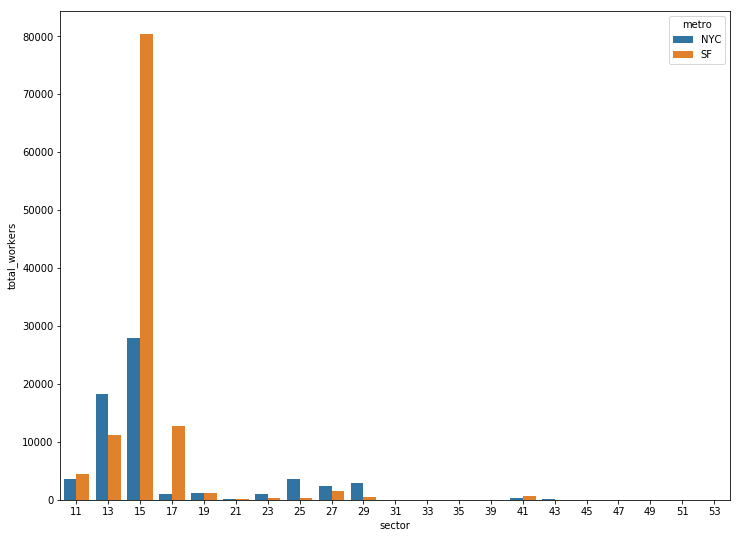

In [39]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)
sns.barplot(x="sector", y="total_workers", hue="metro",
            data=socdf.groupby(["metro", "sector"])["total_workers"].sum().reset_index(),
            ax=ax)

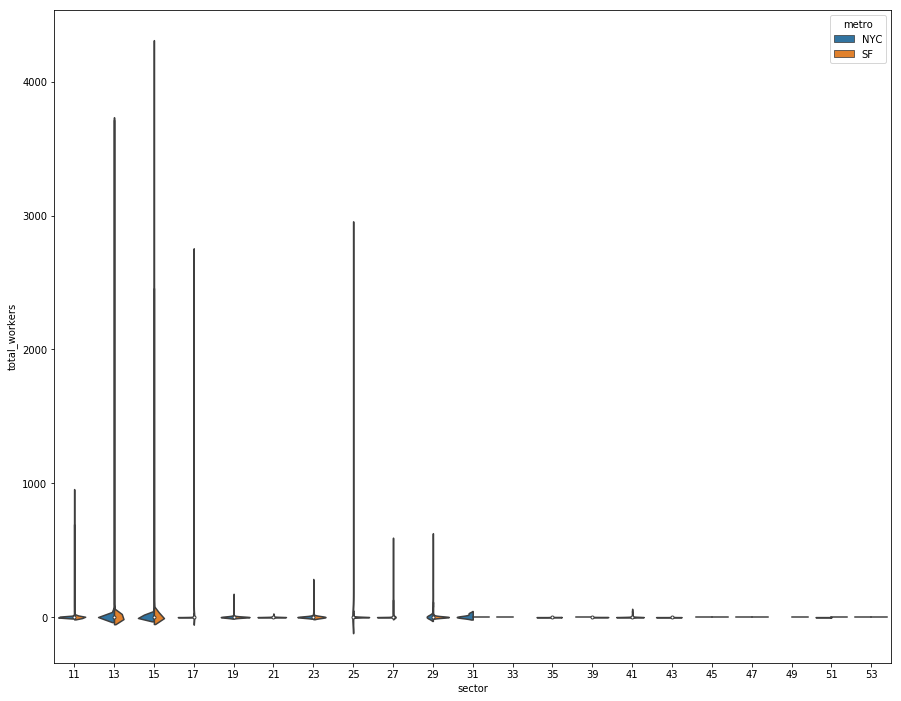

In [64]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)
# how about the distribution of total_workers per company, for a given job category? let's take 11, which is fairly similar
empdf = socdf.groupby(["metro", "sector", "lca_case_employer_name"])["total_workers"].sum().reset_index()
# empdf.groupby(["metro", "sector"]).mean().reset_index()
sns.violinplot(x="sector", y="total_workers", hue="metro", data=empdf, split=True)

(0, 70)

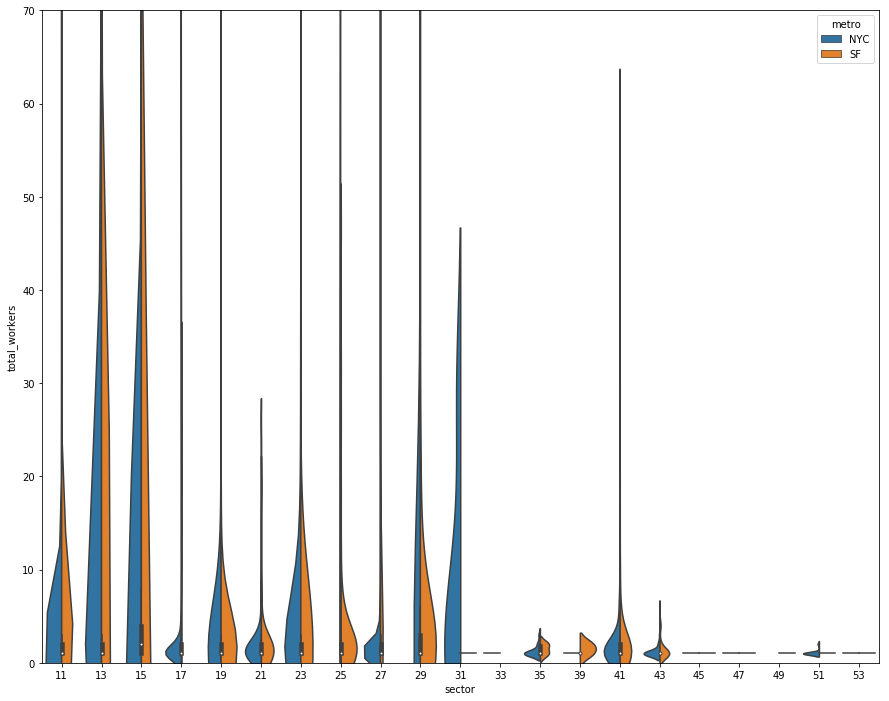

In [66]:
# seems that there are some companies that are outliers,
# moreso than there being a job sector that is an outlier, interestingly
# it's definitely a fat tail effect
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)
sns.violinplot(x="sector", y="total_workers", hue="metro", data=empdf, split=True)
ax.set_ylim([0,70])

In [40]:
nycsfdf["naics_str"] = [str(code) for code in nycsfdf.lca_case_naics_code]

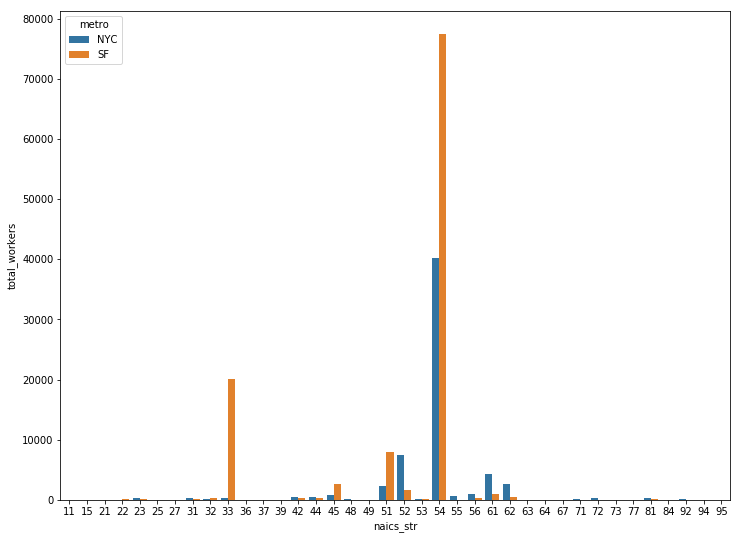

In [47]:
# try the same for industry sector
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)
sns.barplot(x="naics_str", y="total_workers", hue="metro",
            data=nycsfdf.groupby(["metro", "naics_str"])["total_workers"].sum().reset_index(),
            ax=ax)

In [57]:
# Try a company ranking per region and see what we got
comprankdf = nycsfdf.groupby(["metro", "lca_case_employer_name"])["total_workers"].sum().sort_values(ascending=False).reset_index()
comprankdf

,metro,lca_case_employer_name,total_workers
0,NYC,PRICEWATERHOUSECOOPERS LLP,6143.0
1,SF,PRICEWATERHOUSECOOPERS LLP,5987.0
2,SF,APPLE INC,5493.0
3,SF,CISCO SYSTEMS INC,4501.0
4,SF,WIPRO LIMITED,4282.0
5,SF,SYNOPSYS INC,4225.0
6,SF,DELOITTE CONSULTING LLP,3944.0
7,NYC,DELOITTE CONSULTING LLP,3727.0
8,SF,TECH MAHINDRA AMERICAS INC,3544.0
9,NYC,NEW YORK CITY DEPARTMENT OF EDUCATION,2914.0


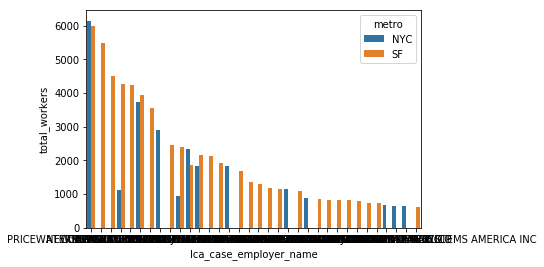

In [60]:
sns.barplot(x="lca_case_employer_name", y="total_workers", hue="metro",
            data=comprankdf.iloc[:40])

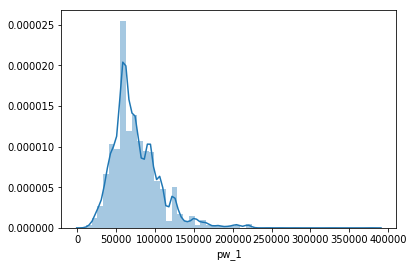

In [67]:
# How about prevailing wages distributions?
sns.distplot(nycdf.pw_1.dropna())

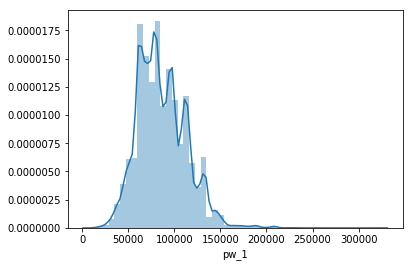

In [68]:
sns.distplot(sfdf.pw_1.dropna())

In [74]:
baygeo = gpd.GeoSeries(bayzips.the_geom)

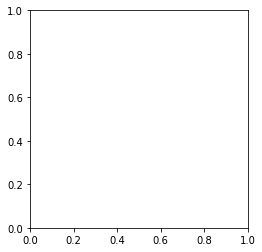

In [75]:
baygeo.plot()

In [45]:
bayzips.the_geom

0      MULTIPOLYGON (((-122.10329200180091 38.5132829...
1      MULTIPOLYGON (((-121.947475002335 38.301511000...
2      MULTIPOLYGON (((-121.65335500334429 38.3133870...
3      MULTIPOLYGON (((-122.406843003057 38.155681999...
4      MULTIPOLYGON (((-122.29368500225117 38.1552379...
5      MULTIPOLYGON (((-122.45766900253919 38.1168949...
6      MULTIPOLYGON (((-121.8624620022998 38.06602999...
7      MULTIPOLYGON (((-121.89653900297888 38.2865679...
8      MULTIPOLYGON (((-122.20418700285576 38.2096949...
9      MULTIPOLYGON (((-122.48655900081091 38.1005269...
10     MULTIPOLYGON (((-122.48655900081091 38.1005269...
11     MULTIPOLYGON (((-121.8861390034904 38.12559299...
12     MULTIPOLYGON (((-122.22853700371564 38.1259699...
13     MULTIPOLYGON (((-122.064180002481 38.118817000...
14     MULTIPOLYGON (((-122.27408000249419 38.1109719...
15     MULTIPOLYGON (((-122.22853700371564 38.1259699...
16     MULTIPOLYGON (((-122.5407480037163 38.07354500...
17     MULTIPOLYGON (((-122.228

In [49]:
gzip = gpd.GeoSeries(bayzips.the_geom)
gzip[0].geometry
gpd.
# for row in bayzips.the_geom.values.tolist().flatten:
#     print(row.geometry)
    
#     indf = gpd.GeoDataFrame.from_file(indata)
#     outdf = gpd.GeoDataFrame(columns=indf.columns)
#     for idx, row in indf.iterrows():
#         if type(row.geometry) == Polygon:
#             outdf = outdf.append(row,ignore_index=True)
#         if type(row.geometry) == MultiPolygon:
#             multdf = gpd.GeoDataFrame(columns=indf.columns)
#             recs = len(row.geometry)
#             multdf = multdf.append([row]*recs,ignore_index=True)
#             for geom in range(recs):
#                 multdf.loc[geom,'geometry'] = row.geometry[geom]
#             outdf = outdf.append(multdf,ignore_index=True)
# return outdf

AttributeError: 'str' object has no attribute 'geometry'

,Unnamed: 0,lca_case_number,lca_case_submit,decision_date,visa_class,lca_case_employment_start_date,lca_case_employment_end_date,lca_case_employer_name,lca_case_employer_address,lca_case_employer_city,...,other_wage_source_2,yr_source_pub_2,lca_case_naics_code,intzips,emp_full_addr,emp_unique_addrs,n_unique_addrs,soc_fam,seniority,frac_wage_rate_to
67,67,I-200-10183-037245,2014-09-02,2014-09-08,H-1B,2015-02-01,2016-01-31,THE JOHNS HOPKINS UNIVERSITY,1620 MCELDERRY STREET,BALTIMORE,...,NaN,NaN,61,21205.0,1620 MCELDERRY STREET BALTIMORE MD 21205,1620 MCELDERRY STREET BALTIMORE MD 21205,1,19.0,0,0.000000
71,71,I-200-10228-828212,2014-09-02,2014-09-08,H-1B,2015-01-15,2018-01-14,THE JOHNS HOPKINS UNIVERSITY,1620 MCELDERRY STREET,BALTIMORE,...,NaN,NaN,61,21205.0,1620 MCELDERRY STREET BALTIMORE MD 21205,1620 MCELDERRY STREET BALTIMORE MD 21205,1,19.0,0,0.000000
110,110,I-200-10337-130227,2014-09-16,2014-09-22,H-1B,2015-02-01,2016-09-28,THE JOHNS HOPKINS UNIVERSITY,1620 MCELDERRY STREET,BALTIMORE,...,NaN,NaN,61,21205.0,1620 MCELDERRY STREET BALTIMORE MD 21205,1620 MCELDERRY STREET BALTIMORE MD 21205,2,19.0,0,0.000000
172,172,I-200-11125-955355,2014-09-12,2014-09-18,H-1B,2015-02-03,2015-08-31,THE JOHNS HOPKINS UNIVERSITY,1620 MCELDERRY STREET,BALTIMORE,...,NaN,NaN,61,21205.0,1620 MCELDERRY STREET BALTIMORE MD 21205,1620 MCELDERRY STREET BALTIMORE MD 21205,2,17.0,0,0.000000
231,231,I-200-11256-354290,2014-09-15,2014-09-19,H-1B,2015-01-23,2017-11-25,CCH INCORPORATED,2700 LAKE COOK ROAD,RIVERWOODS,...,NaN,NaN,51,60015.0,2700 LAKE COOK ROAD RIVERWOODS IL 60015,2700 LAKE COOK ROAD RIVERWOODS IL 60015,1,15.0,1,0.291008
326,326,I-200-12044-865980,2014-08-18,2014-08-24,H-1B,2015-01-06,2018-01-05,TMOBILE USA INC,12920 SE 38TH ST,BELLEVUE,...,NaN,NaN,51,98006.0,12920 SE 38TH ST BELLEVUE WA 98006,12920 SE 38TH ST BELLEVUE WA 98006,1,15.0,1,0.069987
1225,1225,I-200-13102-177821,2014-08-29,2014-09-05,H-1B,2015-01-15,2018-01-14,SALEM STATE UNIVERSITY,352 LAFAYETTE STREET,SALEM,...,NaN,NaN,61,NaN,352 LAFAYETTE STREET SALEM MA 1970,352 LAFAYETTE STREET SALEM MA 1970,1,43.0,0,0.181818
2453,2453,I-200-13259-834156,2014-09-12,2014-09-18,H-1B,2015-01-13,2018-01-13,NANOSYN INC,3100 CENTRAL EXPRESSWAY,SANTA CLARA,...,NaN,NaN,54,95051.0,3100 CENTRAL EXPRESSWAY SANTA CLARA CA 95051,3100 CENTRAL EXPRESSWAY SANTA CLARA CA 95051,1,19.0,0,0.000000
11778,11778,I-200-13291-467250,2014-08-27,2014-09-04,H-1B,2015-01-02,2018-01-02,RTKL ASSOCIATES INC,901 SOUTH BOND STREET,BALTIMORE,...,NaN,NaN,54,21231.0,901 SOUTH BOND STREET BALTIMORE MD 21231,901 SOUTH BOND STREET BALTIMORE MD 21231,1,17.0,0,0.000000
34677,34677,I-200-13312-585985,2014-08-14,2014-08-20,H-1B,2015-02-13,2018-02-12,ISRAEL DISCOUNT BANK OF NEW YORK,511 FIFTH AVENUE,NEW YORK,...,NaN,NaN,52,10017.0,511 FIFTH AVENUE NEW YORK NY 10017,511 FIFTH AVENUE NEW YORK NY 10017,1,13.0,0,0.725449
